In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from matplotlib.ticker import PercentFormatter

In [3]:
# res = pd.read_csv('theoretical_synthesizability_rate.csv')
test_cos_sym = pd.read_csv(f'../../schnet_pred/results/test_df_aug_75_symmetrical_5_noise_10_DOE_20_DOI_aug_75_cos_sym_sc_predictions.csv')
imat_cos_sym = pd.read_csv(f'../../schnet_pred/results/iMatGen_V_Os_5_noise_10_DOE_20_DOI_aug_75_cos_sym_sc_predictions.csv')
wbm_cos_sym = pd.read_csv('../../schnet_pred/results/wbm_oxides_5_noise_10_DOE_20_DOI_aug_75_cos_sym_sc_predictions.csv')
oqmd_75_cos_sym = pd.read_csv('../../schnet_pred/results/oqmd_df_5_noise_10_DOE_20_DOI_aug_75_cos_sym_sc_predictions.csv')

In [4]:
Ttest = test_cos_sym[test_cos_sym.synth==0]
Etest = test_cos_sym[test_cos_sym.synth==1]

In [5]:
# List of dataframes
data_list = [Ttest, imat_cos_sym, wbm_cos_sym, oqmd_75_cos_sym]

# Corresponding labels for the box plots
labels = ['MP Theoretical Oxides test-set', 'iMatGen V-O', 'WBM Oxides', 'OQMD Oxides']
fig_main_title = 'Synthesizability Score Distributions for Theoretical Databases'

In [6]:
len(Ttest), len(Etest), test_cos_sym.synth_labels.mean() #symmetrical

(3626, 1554, 0.5)

In [7]:
print(f'{100*(test_cos_sym.synth_labels==test_cos_sym.pred_synth).mean():.1f}')

90.5


In [8]:
Etest.pred_synth.mean(), Ttest.pred_synth.mean()

(0.8687258687258688, 0.2702702702702703)

In [10]:
dupdf = pd.read_csv('../../schnet_pred/duplicate_materials_by_composition.csv')
synthDF = pd.read_pickle('../clean_data/synthDF')

In [11]:
dupdf = synthDF[['material_id','synth', ]].merge(dupdf, left_on='material_id', right_on='synthDF_material_id', how='inner')
Edupdf = dupdf[dupdf.synth==1]
Eoqmd = oqmd_75_cos_sym.merge(Edupdf, left_on='material_id', right_on='oqmd_material_id', how='inner')
# Perform a left merge with an indicator
merged_df = oqmd_75_cos_sym.merge(Edupdf, left_on='material_id', right_on='oqmd_material_id', how='left', indicator=True)
# Filter to keep only the rows that are present in oqmd_75_cos_sym but not in Edupdf
Toqmd = merged_df[merged_df['_merge'] == 'left_only'].drop(columns=['_merge'])
len(Toqmd), len(imat_cos_sym)


(23056, 10981)

In [12]:
imat_cos_sym.material_id = imat_cos_sym.material_id.str.replace('POSCAR_mp-', '').str.replace('.vasp', '')

# There only numerical differences between these inputs. We remove duplicates here.
# Extract the numeric part of 'file_name'
imat_cos_sym['numeric_part'] = imat_cos_sym['material_id'].str.extract(r'^(\d+)', expand=False)

# Drop duplicates based on 'numeric_part' to get the first instances for imat_cos_sym1
imat_cos_sym_1 = imat_cos_sym.drop_duplicates(subset='numeric_part', keep='first').copy()

# Remove imat_cos_sym1 entries from vodf to get the rest (subsequent instances) for df2
df2 = imat_cos_sym[~imat_cos_sym.index.isin(imat_cos_sym_1.index)].copy()

# Now remove the 'numeric_part' column if it's not needed in the final DataFrames
imat_cos_sym_1.drop(columns='numeric_part', inplace=True)
df2.drop(columns='numeric_part', inplace=True)

In [13]:
data_list_clean = [Ttest, imat_cos_sym_1, wbm_cos_sym, Toqmd]
labels_clean = ['MP Theoretical Oxides test-set', 'iMatGen V-O', 'WBM Oxides', 'OQMD Theoretical Oxides']

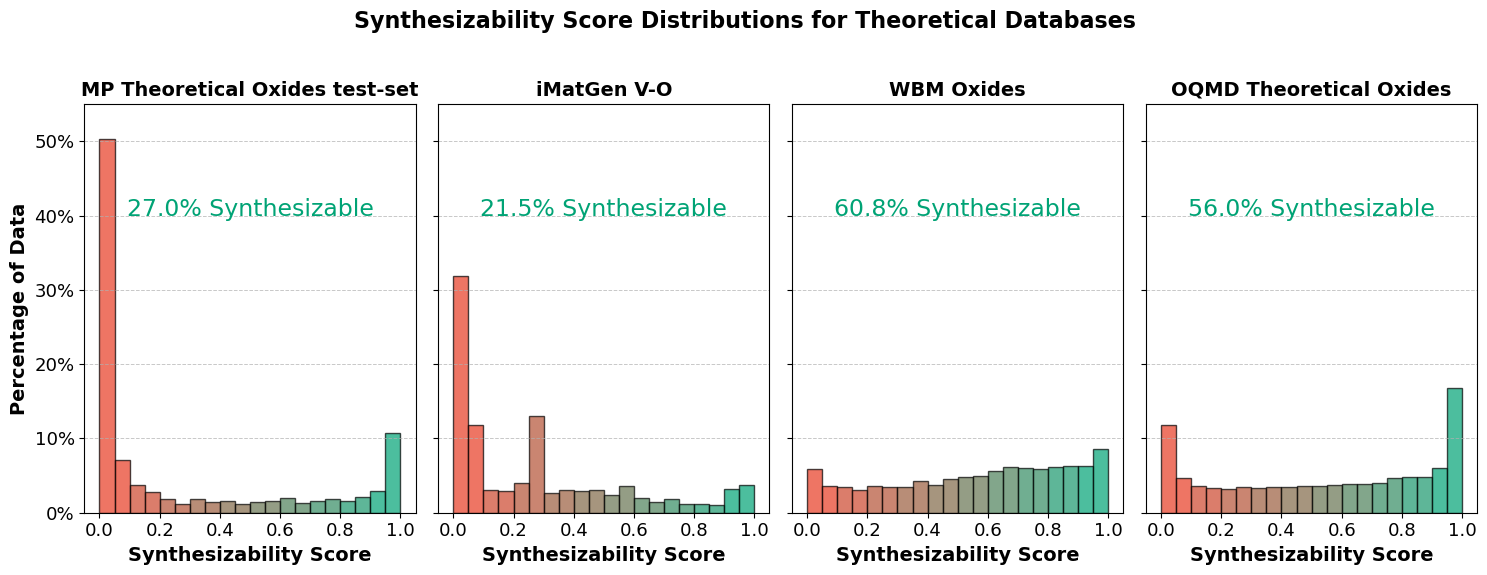

In [14]:
# Create subplots for each histogram (one row, multiple columns)
fig, axes = plt.subplots(1, len(data_list_clean), figsize=(15, 6), sharey=True)

# Create a custom colormap transitioning from red to green
cmap = mcolors.LinearSegmentedColormap.from_list("red_green", ["#E73A23", "#00A375"], N=10)

# Iterate over data and create a normalized histogram for each
for i, df in enumerate(data_list_clean):
    # Plot normalized histogram
    weights = (1 / len(df['synth_score'])) * 100  
    counts, bins, patches = axes[i].hist(
        df['synth_score'], bins=20, edgecolor='black', alpha=0.7, weights=[weights] * len(df['synth_score'])
    )
    
    # Apply a gradient color to each bin
    for j, patch in enumerate(patches):
        # Normalize the index to [0, 1] range for the colormap
        color_value = j / 19  # Normalize to the number of bins (10)
        patch.set_facecolor(cmap(color_value))
    
    # Set title and labels
    axes[i].set_title(labels_clean[i], fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Synthesizability Score', fontsize=14, fontweight='bold')
    if i == 0:  # Only the first plot has the y-label for shared axis
        axes[i].set_ylabel('Percentage of Data', fontsize=14, fontweight='bold')

    # Manually set y-axis limit to 50%
    axes[i].set_ylim(0, 55)

    # Add placeholder text at the same height (adjust x, fix y)
    axes[i].text(0.5, 40, f"{100*(df.pred_synth.mean()):.1f}% Synthesizable", color="#00A375", fontsize=17, ha='center')


    # Convert the y-axis to show percentages
    axes[i].yaxis.set_major_formatter(PercentFormatter())
    
    
    # Set the tick label sizes for each subplot
    axes[i].tick_params(axis='both', which='major', labelsize=13)

# Adjust layout
plt.suptitle(fig_main_title, fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the title

# Adding gridlines to all plots
for ax in axes:
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7)

# Save the figure in high resolution suitable for publications
plt.savefig(f'predicted_synthesizability_rate.pdf')

plt.show()
